In [17]:
import pandas as pd
from tqdm.notebook import tqdm
from kss import split_sentences
from ekonlpy.sentiment import MPCK
import numpy as np

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install git+https://github.com/entelecheia/eKoNLPy.git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/entelecheia/eKoNLPy.git to /tmp/pip-req-build-mbqrhbjn
  Running command git clone -q https://github.com/entelecheia/eKoNLPy.git /tmp/pip-req-build-mbqrhbjn
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [16]:
!pip install kss
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/뉴스원인분석_modeling/data/kia_test.csv')
df = df[['date_cate', 'content','전일비_비율']]
df

,date_cate,content,전일비_비율
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15
...,...,...,...
39905,2022-08-22,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",0.26
39906,2022-08-22,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.26
39907,2022-08-22,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",0.26
39908,2022-08-22,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",0.26


# 텍스트 랭크

In [ ]:
import networkx as nx
new_lines = []
dictCount={}
tag_sen = []
dictBicount={}

ratio = 0.5
max_sen = 4
threshold = 0.005
def similarity(a, b):
    try:
        n = len(a.intersection(b))
        return n / float(len(a) + len(b) - n)
    except:
        return 0
def build_dictCount(sentences):
    for sent in sentences.split('.'):
        temp_lst = []
        temp = Mecab().pos(sent)
        for i in temp:
            if i[1] in ('NNG', 'NNP', 'VV', 'VA'):
                temp_lst.append(i)
        tag_sen.append(set(temp_lst))
        dictCount[len(dictCount)] = sent
    return dictCount, tag_sen

def build_dictBiCount(dictCount, tag_sen):
    for i in range(len(dictCount)):
        for j in range(i+1, len(dictCount)):
            s = similarity(tag_sen[i], tag_sen[j])
            if s < threshold:
                continue
            dictBicount[i, j] = s
    return dictBicount

def build(dictCount, dictBicount):
    graph = nx.Graph()
    graph.add_nodes_from(dictCount.keys())
    for (a, b), n in dictBicount.items():
        graph.add_edge(a, b, weight=n*1.0 + (1-1.0))
    return graph

def pagerank(graph):
    rank = nx.pagerank(graph, weight='weight')
    return rank


def new_line(rank, dictCount):
    ks = sorted(rank, key=rank.get, reverse=True)
    score = int(len(rank)*ratio)

    if score < max_sen :
        score = int(len(rank)*ratio)
    elif score >= max_sen:
        score = max_sen
    else:
        pass

    if score == 0:
        score = len(rank)

    ks = ks[:score]
    new_text = '.'.join(map(lambda k: dictCount[k], sorted(ks)))
    return new_text 

In [ ]:
new_lines = []
from konlpy.tag import Mecab
mecab = Mecab()
for idx, text in tqdm(enumerate(df['content'])):
    dictCount={}
    tag_sen = []
    dictBicount={}
    # try:
    dictCount, tag_sen = build_dictCount(text)
    dictBicount = build_dictBiCount(dictCount, tag_sen)
    graph = build(dictCount, dictBicount)
    rank = pagerank(graph)
    new_text = new_line(rank, dictCount)
    new_lines.append(new_text)
    # except:
    #     print(idx)
    #     break
df['text_rank_content'] = new_lines
df

0it [00:00, ?it/s]

,date_cate,content,전일비_비율,text_rank_content
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ..."
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...
...,...,...,...,...
39905,2022-08-22,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",0.26,"지수는 전장보다 25. 이날 서울 외환시장에서 원달러 환율은 장중 1,330원을 ..."
39906,2022-08-22,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.26,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...
39907,2022-08-22,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",0.26,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기..."
39908,2022-08-22,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",0.26,미국은 탈레반이 지난해 8월 친미 아프간 정부를 무너뜨리고 아프간을 장악하자 미국...


(array([3.4649e+04, 4.7800e+03, 3.5800e+02, 7.7000e+01, 2.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00]),
 array([   20.   ,  1979.375,  3938.75 ,  5898.125,  7857.5  ,  9816.875,
        11776.25 , 13735.625, 15695.   ]),
 <a list of 8 Patch objects>)

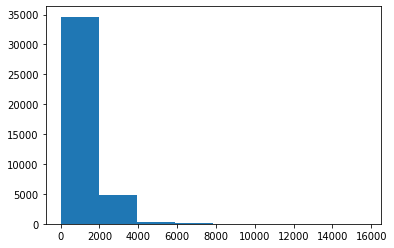

In [ ]:
df['len'] = df['content'].apply(len)
import matplotlib.pyplot as plt
plt.hist(df['len'], bins=8)

(array([3.975e+04, 1.430e+02, 7.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([3.00000e+00, 1.34530e+03, 2.68760e+03, 4.02990e+03, 5.37220e+03,
        6.71450e+03, 8.05680e+03, 9.39910e+03, 1.07414e+04, 1.20837e+04,
        1.34260e+04]),
 <a list of 10 Patch objects>)

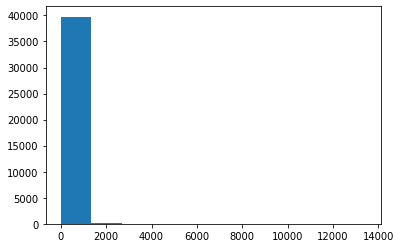

In [ ]:
df['text_rank_len'] = df['text_rank_content'].apply(len)
import matplotlib.pyplot as plt
plt.hist(df['text_rank_len'])

In [ ]:
df['text_rank_len'].describe()

count    39910.000000
mean       273.532799
std        212.718098
min          3.000000
25%        185.000000
50%        256.000000
75%        334.000000
max      13426.000000
Name: text_rank_len, dtype: float64

In [ ]:
# 전일비 기준
df['target'] = np.where(df['전일비_비율'] <= -5, 0,
                        np.where(df['전일비_비율'] <= -0.5, 1,
                                 np.where(df['전일비_비율'] <= 0.5, 2,
                                          np.where(df['전일비_비율'] <= 5, 3, 4                                                                   
                        ))))
df

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2
...,...,...,...,...,...,...,...
39905,2022-08-22,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",0.26,"지수는 전장보다 25. 이날 서울 외환시장에서 원달러 환율은 장중 1,330원을 ...",1729,86,2
39906,2022-08-22,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.26,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,89,54,2
39907,2022-08-22,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",0.26,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",907,456,2
39908,2022-08-22,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",0.26,미국은 탈레반이 지난해 8월 친미 아프간 정부를 무너뜨리고 아프간을 장악하자 미국...,983,376,2


In [ ]:
df['target'].value_counts()

1    14636
3    13858
2     9484
4     1434
0      498
Name: target, dtype: int64

In [ ]:
mpck = MPCK()
# 긍부정 비율 점수 + 그날 주가변동 점수 + 보정치 0.5
from tqdm.notebook import tqdm
for idx in tqdm(df.index):
  # 긍부정 mpck
  temp_text = df.loc[idx, 'content']
  target = df.loc[idx, 'target']
  tokens = mpck.tokenize(temp_text)
  ngrams = mpck.ngramize(tokens)
  score = mpck.classify(tokens + ngrams, intensity_cutoff=1.3 )
  # kss
  sent_list = split_sentences(temp_text)
  # # 문장별 토큰 복원
  # sent_tok_list = []
  # for sent in sent_list :
  #   tokens = mpck.tokenize(sent)
  #   ngrams = mpck.ngramize(sent)
  #   temp_token = tokens + ngrams
  #   tok_list = [re.sub('[^ㄱ-ㅎ가-힣 ]','' ,tok) for tok in temp_token]
  #   sent_tok_list.append(' '.join(tok_list))
  # 점수 계산
  score_dif = score['Pos score'] - score['Neg score']
  df.loc[idx, 'mpc_pos'] = score['Pos score']
  df.loc[idx, 'mpc_neg'] = score['Neg score']
  df.loc[idx, 'mpck_token'] = ' [SEP] '.join(sent_list)
  df.loc[idx, 'score_diff'] = score_dif
  df.loc[idx, 'score_diff+tar'] = score_dif+ (df.loc[idx, 'target'] * (0.5)) + 0.5
df.head(20)

  0%|          | 0/39910 [00:00<?, ?it/s]

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,9.960439e-01,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,3.168241e-06,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,1.344403e-05,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,3.493616e-05,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,1.425929e-01,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186
5,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,-0.15,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,789,299,2,9.996573e-01,0.000343,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,0.999315,2.499315
6,2017-12-04,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",-0.15,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",1069,274,2,9.965403e-01,0.003460,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",0.993081,2.493081
7,2017-12-04,"현대기아차, 올해 내수 목표치 가시권나머지는 물 건너가이데일리 노재웅 기자 한 해를...",-0.15,이달 비슷한 수준의 판매 실적을 올린다면 약 69만3000대로 올해 목표량인 68...,2299,209,2,1.098262e-03,0.998902,"현대기아차, 올해 내수 목표치 가시권나머지는 물 건너가이데일리 노재웅 기자 한 해를...",-0.997803,0.502197
8,2017-12-04,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,-0.15,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,1851,387,2,9.797455e-01,0.020255,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,0.959491,2.459491
9,2017-12-04,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",-0.15,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",1108,252,2,4.111699e-06,0.999996,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",-0.999992,0.500008


In [ ]:
df['pos_neg'] = np.where(df['score_diff'] >0, 'pos', 'neg')
df['pos_neg_tardiff'] = np.where(df['score_diff+tar'] >0, 'pos', 'neg')
df['target'].value_counts()

1    14636
3    13858
2     9484
4     1434
0      498
Name: target, dtype: int64

In [ ]:
df['pos_neg'].value_counts()

neg    29736
pos    10174
Name: pos_neg, dtype: int64

In [ ]:
df['pos_neg_tardiff'].value_counts()

pos    39424
neg      486
Name: pos_neg_tardiff, dtype: int64

In [ ]:
from sklearn.cluster import KMeans
kmm = KMeans(n_clusters=5, random_state=2022)
kmm.fit(df[['score_diff+tar']])
df['kmm_label'] = kmm.labels_
df.head(20)

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar,pos_neg,pos_neg_tardiff,kmm_label
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,9.960439e-01,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088,pos,pos,2
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,3.168241e-06,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006,neg,pos,0
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,1.344403e-05,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027,neg,pos,0
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,3.493616e-05,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070,neg,pos,0
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,1.425929e-01,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186,neg,pos,3
5,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,-0.15,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,789,299,2,9.996573e-01,0.000343,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,0.999315,2.499315,pos,pos,2
6,2017-12-04,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",-0.15,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",1069,274,2,9.965403e-01,0.003460,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",0.993081,2.493081,pos,pos,2
7,2017-12-04,"현대기아차, 올해 내수 목표치 가시권나머지는 물 건너가이데일리 노재웅 기자 한 해를...",-0.15,이달 비슷한 수준의 판매 실적을 올린다면 약 69만3000대로 올해 목표량인 68...,2299,209,2,1.098262e-03,0.998902,"현대기아차, 올해 내수 목표치 가시권나머지는 물 건너가이데일리 노재웅 기자 한 해를...",-0.997803,0.502197,neg,pos,0
8,2017-12-04,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,-0.15,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,1851,387,2,9.797455e-01,0.020255,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,0.959491,2.459491,pos,pos,2
9,2017-12-04,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",-0.15,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",1108,252,2,4.111699e-06,0.999996,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",-0.999992,0.500008,neg,pos,0


In [ ]:
df_gr = df.groupby('kmm_label')[['score_diff+tar']].mean().sort_values('score_diff+tar')
df_gr

,score_diff+tar
kmm_label,
4,-0.001198
0,0.519860
3,1.046312
1,1.842549
2,2.797676


In [ ]:
df_dict = {}
df_ndict = {}
label_list = ['매우하락', '하락', '중간', '상승', '매우상승']
label_nlist = [0, 1, 2, 3, 4]
for idx in range(len(df_gr.index)):
  df_dict[df_gr.index[idx]] = label_list[idx]
  df_ndict[df_gr.index[idx]] = label_nlist[idx]
df['kmm_label_n5'] = df['kmm_label'].apply(lambda x : df_dict[x])
df['kmm_label_n_n5'] = df['kmm_label'].apply(lambda x : df_ndict[x])
df.head(20)

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar,pos_neg,pos_neg_tardiff,kmm_label,kmm_label_n5,kmm_label_n_n5
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,9.960439e-01,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088,pos,pos,2,매우상승,4
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,3.168241e-06,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006,neg,pos,0,하락,1
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,1.344403e-05,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027,neg,pos,0,하락,1
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,3.493616e-05,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070,neg,pos,0,하락,1
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,1.425929e-01,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186,neg,pos,3,중간,2
5,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,-0.15,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,789,299,2,9.996573e-01,0.000343,현대기아차 북미시장 고전 지속코나스팅어 기대11월에도 현대차와 기아차가 북미 시장에...,0.999315,2.499315,pos,pos,2,매우상승,4
6,2017-12-04,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",-0.15,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",1069,274,2,9.965403e-01,0.003460,"현대기아차, 11월 북미판매 동반부진신차로 활로이데일리 노재웅 기자 현대기아자동차가...",0.993081,2.493081,pos,pos,2,매우상승,4
7,2017-12-04,"현대기아차, 올해 내수 목표치 가시권나머지는 물 건너가이데일리 노재웅 기자 한 해를...",-0.15,이달 비슷한 수준의 판매 실적을 올린다면 약 69만3000대로 올해 목표량인 68...,2299,209,2,1.098262e-03,0.998902,"현대기아차, 올해 내수 목표치 가시권나머지는 물 건너가이데일리 노재웅 기자 한 해를...",-0.997803,0.502197,neg,pos,0,하락,1
8,2017-12-04,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,-0.15,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,1851,387,2,9.797455e-01,0.020255,일자리 창출 충북에서 배워라충북도내 일자리 증가율 1위 제천시 경쟁력은제천이데일리 ...,0.959491,2.459491,pos,pos,2,매우상승,4
9,2017-12-04,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",-0.15,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",1108,252,2,4.111699e-06,0.999996,"기아차, 2018년형 7 출시부분 자율주행 기술 탑재이데일리 노재웅 기자 기아자동차...",-0.999992,0.500008,neg,pos,0,하락,1


In [ ]:
df

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar,pos_neg,pos_neg_tardiff,kmm_label,kmm_label_n5,kmm_label_n_n5
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,9.960439e-01,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088,pos,pos,2,매우상승,4
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,3.168241e-06,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006,neg,pos,0,하락,1
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,1.344403e-05,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027,neg,pos,0,하락,1
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,3.493616e-05,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070,neg,pos,0,하락,1
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,1.425929e-01,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186,neg,pos,3,중간,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39905,2022-08-22,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",0.26,"지수는 전장보다 25. 이날 서울 외환시장에서 원달러 환율은 장중 1,330원을 ...",1729,86,2,1.768957e-07,1.000000,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",-1.000000,0.500000,neg,pos,0,하락,1
39906,2022-08-22,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.26,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,89,54,2,5.642329e-01,0.435767,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.128466,1.628466,pos,pos,1,상승,3
39907,2022-08-22,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",0.26,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",907,456,2,1.326228e-07,1.000000,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",-1.000000,0.500000,neg,pos,0,하락,1
39908,2022-08-22,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",0.26,미국은 탈레반이 지난해 8월 친미 아프간 정부를 무너뜨리고 아프간을 장악하자 미국...,983,376,2,1.319802e-05,0.999987,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",-0.999974,0.500026,neg,pos,0,하락,1


In [ ]:
df.to_csv('/content/drive/MyDrive/뉴스원인분석_modeling/data/kia_text_rank_max_kss.csv', index=False)

In [1]:
 import pandas as pd
 df2 = pd.read_csv('/content/drive/MyDrive/뉴스원인분석_modeling/data/kia_text_rank_max_kss.csv')
 df2

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar,pos_neg,pos_neg_tardiff,kmm_label,kmm_label_n5,kmm_label_n_n5
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,9.960439e-01,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088,pos,pos,2,매우상승,4
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,3.168241e-06,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006,neg,pos,0,하락,1
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,1.344403e-05,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027,neg,pos,0,하락,1
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,3.493616e-05,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070,neg,pos,0,하락,1
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,1.425929e-01,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186,neg,pos,3,중간,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39905,2022-08-22,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",0.26,"지수는 전장보다 25. 이날 서울 외환시장에서 원달러 환율은 장중 1,330원을 ...",1729,86,2,1.768957e-07,1.000000,"코스피 장중 2,450대로 추락환율, 급등하며 1,340원 근접종합서울연합뉴스 이미...",-1.000000,0.500000,neg,pos,0,하락,1
39906,2022-08-22,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.26,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,89,54,2,5.642329e-01,0.435767,기아의 유럽 전략형 모델 씨드서울연합뉴스 기아의 유럽 맞춤형 전략 차종인 씨드eed...,0.128466,1.628466,pos,pos,1,상승,3
39907,2022-08-22,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",0.26,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",907,456,2,1.326228e-07,1.000000,"현대차그룹엔솔 인니 배터리셀 합작공장, 약 1조원 투자금 확보서울연합뉴스 최평천 기...",-1.000000,0.500000,neg,pos,0,하락,1
39908,2022-08-22,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",0.26,미국은 탈레반이 지난해 8월 친미 아프간 정부를 무너뜨리고 아프간을 장악하자 미국...,983,376,2,1.319802e-05,0.999987,"미, 탈레반과 아프간 동결 자산 해제 협상 계속 추진서울연합뉴스 김정은 기자 미국...",-0.999974,0.500026,neg,pos,0,하락,1


In [2]:
!pip install git+https://github.com/lovit/textrank.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lovit/textrank.git to /tmp/pip-req-build-eaiwe0cc
  Running command git clone -q https://github.com/lovit/textrank.git /tmp/pip-req-build-eaiwe0cc


In [3]:
from konlpy.tag import Komoran

komoran = Komoran()
def komoran_tokenizer(sent):
    words = komoran.pos(sent, join=True)
    words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    return words

In [4]:
txt1 = df2.loc[2, 'mpck_token']
txt1

'뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자자동차 뒷좌석에 앉은 어린이들의 충돌 안전도를 평가한 결과 어린이 보호좌석카시트을 장착하지 않은 10세 아동보다 카시트를 장착한 6세 아동에 대한 충격이 더욱 크게 나타나 주목된다. [SEP] 도로교통공단 자동차안전연구원이 운영하는 한국 신차안전도 평가 프로그램은 최근 올해 어린이 충돌 안전성 평가가 진행된 2017년형 5개 자동차 모델에 대한 평가 결과를 공개했다. [SEP] 이번에 현대차 그랜저와 i30. 한국지엠 크루즈, 쌍용차 4렉스턴, 도요타의 프리우스 등의 결과가 공개됐으며, 올해 말까지 기아차의 모닝과 스팅어, 현대차 코나, 벤츠 220,  520d, 혼다  등에 대한 평가 결과도 공개될 예정이다. [SEP] 뒷좌석 어린이 충돌 안정성의 경우 시속 64kmh 속도로 진행되는 부분 정면충돌 안전성과 시속 55kmh 속도로 진행된 측면충돌 안전성 평가로 진행됐다. [SEP] 측면 충돌 안정성의 경우 5개 모델 모두 우수한 것으로 나타났지만, 부분 정명충돌의 경우 모델별 차이가 크게 나타났다. [SEP] 특히 뒷좌석에 카시트 없이 앉은 10세 아동과 카시트를 장착하고 앉은 6세 아동에 대한 부분 정면충돌 결과는 6세 아동에 대한 충격이 10세 아동보다 더욱 큰 것으로 나타났다. [SEP] 그랜저의 경우 카시트를 장착한 6세 아동이 더 잘 보호되는 것으로 나타났지만, 나머지 모델은 모두 10세 아동보다 6세 아동에 대한 충격이 더욱 큰 것으로 평가 결과가 나왔다. [SEP] 평가 결과는 인체 모형의 머리, 목, 흉부 등 3가지 부분에 대해 우수, 양호, 보통, 미흡, 열등 등 5가지 등급으로 제시된다. [SEP] 먼저 프리우스의 경우 6세 아동은 흉부 부분의 안전성이 미흡했지만, 10세 아동은 머리, 목, 흉부 모도 우수한 안전도를 보였다. [SEP] 4렉스턴은 6세 아동은 목과 흉부가 각각 양호, 열등을 기록했다. [SEP] 반면 10세 아동은 목 부분만 양호를 기록했을

In [5]:
txt_list = txt1.split(' [SEP] ')
txt_list

['뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자자동차 뒷좌석에 앉은 어린이들의 충돌 안전도를 평가한 결과 어린이 보호좌석카시트을 장착하지 않은 10세 아동보다 카시트를 장착한 6세 아동에 대한 충격이 더욱 크게 나타나 주목된다.',
 '도로교통공단 자동차안전연구원이 운영하는 한국 신차안전도 평가 프로그램은 최근 올해 어린이 충돌 안전성 평가가 진행된 2017년형 5개 자동차 모델에 대한 평가 결과를 공개했다.',
 '이번에 현대차 그랜저와 i30. 한국지엠 크루즈, 쌍용차 4렉스턴, 도요타의 프리우스 등의 결과가 공개됐으며, 올해 말까지 기아차의 모닝과 스팅어, 현대차 코나, 벤츠 220,  520d, 혼다  등에 대한 평가 결과도 공개될 예정이다.',
 '뒷좌석 어린이 충돌 안정성의 경우 시속 64kmh 속도로 진행되는 부분 정면충돌 안전성과 시속 55kmh 속도로 진행된 측면충돌 안전성 평가로 진행됐다.',
 '측면 충돌 안정성의 경우 5개 모델 모두 우수한 것으로 나타났지만, 부분 정명충돌의 경우 모델별 차이가 크게 나타났다.',
 '특히 뒷좌석에 카시트 없이 앉은 10세 아동과 카시트를 장착하고 앉은 6세 아동에 대한 부분 정면충돌 결과는 6세 아동에 대한 충격이 10세 아동보다 더욱 큰 것으로 나타났다.',
 '그랜저의 경우 카시트를 장착한 6세 아동이 더 잘 보호되는 것으로 나타났지만, 나머지 모델은 모두 10세 아동보다 6세 아동에 대한 충격이 더욱 큰 것으로 평가 결과가 나왔다.',
 '평가 결과는 인체 모형의 머리, 목, 흉부 등 3가지 부분에 대해 우수, 양호, 보통, 미흡, 열등 등 5가지 등급으로 제시된다.',
 '먼저 프리우스의 경우 6세 아동은 흉부 부분의 안전성이 미흡했지만, 10세 아동은 머리, 목, 흉부 모도 우수한 안전도를 보였다.',
 '4렉스턴은 6세 아동은 목과 흉부가 각각 양호, 열등을 기록했다.',
 '반면 10세 아동은 목 부분만 양호를 기록했을 뿐, 나머지 머리와 흉부는 모두 

In [7]:
from textrank import KeywordSummarizer

summarizer = KeywordSummarizer(tokenize=komoran_tokenizer, min_count=2, min_cooccurrence=1)
temp_sum = summarizer.summarize(txt_list, topk=20)
temp_sum

[('세/NNB', 3.729595728150004),
 ('어린이/NNG', 3.5909875513621166),
 ('아동/NNG', 2.9538886980088646),
 ('평가/NNG', 2.657345279372077),
 ('충돌/NNP', 2.1652042027002323),
 ('대하/VV', 1.8565335655979935),
 ('결과/NNG', 1.8252868695124298),
 ('좌석/NNP', 1.7857537746204124),
 ('장착/NNG', 1.7304439034281325),
 ('보호/NNG', 1.7191958523131672),
 ('나타나/VV', 1.6935670800817122),
 ('경우/NNG', 1.685189547087064),
 ('안전/NNG', 1.6478192729783965),
 ('시트/NNG', 1.5662182013075183),
 ('충격/NNG', 1.4931841812085294),
 ('크/VA', 1.48459091330328),
 ('부분/NNG', 1.4609554003967005),
 ('흉부/NNG', 1.270572768134734),
 ('카/NNG', 1.268459442702596),
 ('등/NNB', 1.2204058410933238)]

In [8]:
txt2 = '''
현대자동차그룹의 ‘애플카(가칭)’ 협력설이 새해 시작과 함께 산업계를 뜨겁게 달구고 있다. 다양한 소문과 소식들이 꾸준히 나오고 있는 가운데 그룹 주요 계열사인 ‘기아’를 중심으로 애플카 협력에 관한 퍼즐이 맞춰졌다.
앞서 알려진 대로 기아가 애플카 프로젝트를 맡고 생산은 미국에 있는 기아 조지아공장에서 이뤄진다. 기아와 애플 모두 공식 입장 표명을 자제하고 있지만 현재 계약 수순에 들어간 것으로 취재 결과 확인됐다. 소문과 추측으로 무성했던 애플카 개발 협력이 상당 부분 진전을 보이고 있는 것이다.
3일 취재를 종합하면 기아와 애플은 이달 중 애플카 생산을 위한 4조 원 규모 정식계약을 체결할 계획이다. 지난달부터 정식계약을 위한 실무 조율이 진행 중이며 구체적인 계약 일정까지 잡힌 상태다. 당초 계약 시기를 2월 초로 정했지만 한 차례 미뤄져 2월 17일로 일정이 변경됐다. 다만 회사별 내부 사정에 따라 2월 17일 계약 일정은 변동 가능성이 있는 것으로 전해졌다. 특히 계약 당일에는 정의선 현대차그룹 회장이 직접 계약식에 참석하는 것으로 계획이 잡혔다고 한다. 최근에는 정 회장이 지난달 싱가포르 출장에서 애플 고위 관계자를 만났다는 소식이 전해지기도 했다. 사실 여부는 확인되지 않았다.
이번 계약에는 애플카 생산과 관련된 구체적인 내용이 담길 전망이다. 애플은 기아에 4조 원 규모 투자를 단행할 예정이다. 오는 2024년 출시를 목표로 기아가 생산하는 애플카 물량은 초기 연간 10만대 수준이고 최대 40만대 규모까지 확대 가능하다.
애플이 기아에 투입하는 4조 원은 애플카 생산을 위한 전용 설비 구축과 차량 개발 등에 사용될 전망이다. 이 같은 대규모 초기 투자는 애플이 주요 제품 생산을 추진하는 과정에서 자주 사용하는 방식이기도 하다. 애플은 아이폰과 아이패드 등 기존 주력 제품 생산을 추진할 때도 LG디스플레이(LGD)에 조 단위 투자를 단행한 후 전용 설비에서 생산된 OLED 패널을 수급한 바 있다. 마찬가지로 애플로부터 투자를 유치한 기아는 애플의 전기차 생산을 위한 전용 라인 구축에 나설 것으로 보인다.
애플카 프로젝트에서 기아가 차량 생산을 주도하는 가운데 현대글로비스의 역할에도 관심이 몰린다. 업계 관계자는 “애플카 사업에서 미국에 여러 법인을 둔 글로비스가 비중 있는 역할을 맡게 될 예정”이라고 전했다.
'''
txt_list2 = txt2.split(' [SEP] ')
summarizer = KeywordSummarizer(tokenize=komoran_tokenizer, min_count=2, min_cooccurrence=1)
summarizer.summarize(txt_list2, topk=20)

[('애플/NNP', 4.968604289710914),
 ('카/NNP', 2.685732048492382),
 ('기아/NNP', 2.685732048492382),
 ('생산/NNG', 2.685732048492382),
 ('계약/NNG', 2.178427105999374),
 ('있/VV', 1.6711221635063729),
 ('것/NNB', 1.4174696922598682),
 ('위하/VV', 1.1638172210133644),
 ('규모/NNG', 1.1638172210133644),
 ('투자/NNG', 1.1638172210133644),
 ('협력/NNG', 0.9101647497668637),
 ('원/NNB', 0.9101647497668637),
 ('일정/NNG', 0.9101647497668637),
 ('전하/VV', 0.9101647497668637),
 ('전용/NNG', 0.9101647497668637),
 ('추진/NNG', 0.6565122785203596),
 ('역할/NNG', 0.6565122785203596),
 ('제품/NNG', 0.6565122785203596),
 ('사용/NNG', 0.6565122785203596),
 ('등/NNB', 0.6565122785203596)]

In [9]:
temp_sum[0][0].split('/')[-1][:2]

'NN'

In [10]:
temp_sum[1][0].split('/')[0]

'어린이'

In [24]:
df2.head()

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar,pos_neg,pos_neg_tardiff,kmm_label,kmm_label_n5,kmm_label_n_n5,keyword
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,0.996044,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088,pos,pos,2,매우상승,4,NaN
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,0.000003,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006,neg,pos,0,하락,1,NaN
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,0.000013,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027,neg,pos,0,하락,1,NaN
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,0.000035,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070,neg,pos,0,하락,1,NaN
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,0.142593,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186,neg,pos,3,중간,2,NaN


In [28]:
type(temp_list[0])

str

In [30]:
pd.__version__

'1.3.5'

In [29]:
temp_list

['차',
 '11월',
 '기아',
 '북미',
 '대',
 '스포츠',
 '작년',
 '판매',
 '월간',
 '실적',
 '현대차',
 '대로',
 '스팅어',
 '올해',
 '대차',
 '기대',
 '코',
 '미주',
 '판매']

In [42]:
sent_list

['그래픽 현대기아차 실적 흐림서울연합뉴스 장예진 기자  통상임금 소송 1심 패소에 따른 충당금 적립과 원화 강세, 중국 판매 부진 등이 겹친 기아자동차도 지난해 현대자동차와 마찬가지로 수익성 측면에서 2010년 이후 가장 나쁜 성적표를 받았다.',
 'jin34yna.co.kr']

In [46]:
summarizer = KeywordSummarizer(tokenize=komoran_tokenizer, min_count=2, min_cooccurrence=1)
summarizer_raw = KeywordSummarizer(tokenize=komoran_tokenizer, min_count=0, min_cooccurrence=0)
from tqdm.notebook import tqdm
df2['keyword'] = '한글'
for idx in tqdm(df2.index) :
  temp_content = df2.loc[idx, 'content']
  # kss
  sent_list = split_sentences(temp_content)
  # textrank
  try :
    temp_sum = summarizer.summarize(sent_list, topk=20)
  except :
    try :
      temp_sum = summarizer_raw.summarize(sent_list, topk=5)
    except :
      temp_sum = []
  temp_list = []
  for tok in temp_sum:
    if tok[0].split('/')[-1][:2] == 'NN':
      temp_list.append(tok[0].split('/')[0])
  df2.at[idx, 'keyword'] = temp_list
df2.head()

  0%|          | 0/39910 [00:00<?, ?it/s]

,date_cate,content,전일비_비율,text_rank_content,len,text_rank_len,target,mpc_pos,mpc_neg,mpck_token,score_diff,score_diff+tar,pos_neg,pos_neg_tardiff,kmm_label,kmm_label_n5,kmm_label_n_n5,keyword
0,2017-12-04,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,-0.15,"현대차는 오토쇼에 데뷔한 콤팩트 스포츠유틸리티차 코나ona, 기아차는 2018 ...",958,288,2,0.996044,0.003956,현대기아차 북미시장 고전 지속코나스팅어 기대로스앤젤레스연합뉴스 옥철 특파원 현대차...,0.992088,2.492088,pos,pos,2,매우상승,4,"[차, 11월, 기아, 북미, 대, 스포츠, 작년, 판매, 월간, 실적, 현대차, ..."
1,2017-12-04,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.15,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,1372,473,2,0.000003,0.999997,기업공시12월 1일서울경제 대표이사 손봉영에서 김종호로 변경 인터플렉스 유상증자에...,-0.999994,0.500006,neg,pos,0,하락,1,"[원, 공시, 대표, 이사, 규모, 변경, 계약, 법인, 체결, 지분, 한국거래소,..."
2,2017-12-04,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.15,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,1618,392,2,0.000013,0.999987,뒷좌석 어린이 안전도 평가카시트 장착한 6세 아동 충격 더 크다헤럴드경제박도제 기자...,-0.999973,0.500027,neg,pos,0,하락,1,"[세, 어린이, 아동, 평가, 충돌, 결과, 좌석, 장착, 보호, 경우, 안전, 시..."
3,2017-12-04,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.15,한국은 12월 한 달 동안 전 차종에 대해 515의 할인을 적용한다. 주력 차...,1014,237,2,0.000035,0.999965,"국산차, 연말 파격 할인싼타페 230만원캡티바 500만원이데일리 김보경 기자 국내 ...",-0.999930,0.500070,neg,pos,0,하락,1,"[할인, 만원, 최대, 하이브리드, 혜택, 차종, 티, 제공, 차량, 바, 캡, 등..."
4,2017-12-04,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.15,진에어는 공모청약 경쟁률 134. 동양피스톤은 내연기관용 피스톤을 만드는 회사로 ...,722,133,2,0.142593,0.857407,상장 대목이번주 진에어 등 7개 증시 입성서울연합인포맥스 김경림 기자 이번 주4일...,-0.714814,0.785186,neg,pos,3,중간,2,"[원, 일, 등, 진에어, 개, 청약, 회사, 증시, 이익, 영업, 피스톤, 이번,..."


In [82]:
df2.to_csv('/content/drive/MyDrive/뉴스원인분석_modeling/data/kia_news_keword_covid.csv', index=False)

In [67]:
df_gr = df2.groupby('date_cate')[['keyword']].sum()
df_gr['count'] = df2.groupby('date_cate')[['keyword']].count()
df_gr

,keyword,count
date_cate,,
2017-12-04,"[차, 11월, 기아, 북미, 대, 스포츠, 작년, 판매, 월간, 실적, 현대차, ...",43
2017-12-05,"[차, 현대, 기아, 법인, 해외, 장, 일, 미국, 회의, 내년, 시장, 등, 중...",30
2017-12-06,"[레이, 램프, 부, 디자인, 그릴, 기존, 차, 기아, 적용, 디자인, 배치, 전...",17
2017-12-07,"[차, 일, 판매, 수입, 기간, 중고차, 그랜저, 벤츠, 클래스, 기록, 현대차,...",18
2017-12-08,"[클래스, 수입, 그랜저, 산차, 국, 중고차, 일, 차, 최근, 서울경제, 식, ...",44
...,...,...
2022-08-17,"[현대차, 보수, 원, 회장, 등, 그룹, 상반기, 만원, .co, .kr, 명, ...",43
2022-08-18,"[실적, 업체, 로봇, 증권, 수, 부품, 성장, 원, 목표, 매출, 연구원, 전망...",29
2022-08-19,"[미국, 기차, 우려, 전달, 인플레이션, 감축, 법, 제외, 세액, 측, 채널, ...",26


In [74]:
import collections
df_gr['top10'] = '한글'
for idx in df_gr.index :
  counts = collections.Counter(df_gr.loc[idx,'keyword'])
  top10 = counts.most_common(20) 
  cnt_list = []
  for wrd in top10 :
    text, cnt = wrd
    if cnt >= (df_gr.loc[idx,'count'] * 0.2):
      cnt_list.append(text)
  df_gr.at[idx,'top10'] = cnt_list
df_gr

,keyword,count,top10
date_cate,,,
2017-12-04,"[차, 11월, 기아, 북미, 대, 스포츠, 작년, 판매, 월간, 실적, 현대차, ...",43,"[차, 기아, 판매, 등, 년, 것, 대, 원, 만원]"
2017-12-05,"[차, 현대, 기아, 법인, 해외, 장, 일, 미국, 회의, 내년, 시장, 등, 중...",30,"[차, 등, 기아, 현대, 것, 내년, 시장, 대, 판매, 법인, 해외, 중국, 현..."
2017-12-06,"[레이, 램프, 부, 디자인, 그릴, 기존, 차, 기아, 적용, 디자인, 배치, 전...",17,"[차, 디자인, 기아, 레이, 부, 램프, 그릴, 기존, 적용, 배치, 전면, 것,..."
2017-12-07,"[차, 일, 판매, 수입, 기간, 중고차, 그랜저, 벤츠, 클래스, 기록, 현대차,...",18,"[차, 판매, 등, 일, 대, 기아, 야구장, 주민, 소음, 인근, 소송, 수입, ..."
2017-12-08,"[클래스, 수입, 그랜저, 산차, 국, 중고차, 일, 차, 최근, 서울경제, 식, ...",44,"[차, 등, 시장, 기아, 미국, 현대, 것, 현대차, 내년, 판매, 모델, 원]"
...,...,...,...
2022-08-17,"[현대차, 보수, 원, 회장, 등, 그룹, 상반기, 만원, .co, .kr, 명, ...",43,"[등, 미국, 현대차, 것, 기아, 원, 수, 기차, 년, 국제]"
2022-08-18,"[실적, 업체, 로봇, 증권, 수, 부품, 성장, 원, 목표, 매출, 연구원, 전망...",29,"[등, 기차, 미국, 것, 원, 현대차, 생산, 수, 시장, 법, 혜택, 기아, 그..."
2022-08-19,"[미국, 기차, 우려, 전달, 인플레이션, 감축, 법, 제외, 세액, 측, 채널, ...",26,"[등, 원, 미국, 기차, 보조금, 법, 것, 거래, 일, 외국인]"


In [79]:
idx_list = []
keyword = '코로나'
for idx in df_gr.index :
  temp_top10 = df_gr.loc[idx, 'top10']
  if keyword in temp_top10 :
    idx_list.append(idx)
df_gr.loc[idx_list, :]

,keyword,count,top10
date_cate,,,
2020-02-10,"[일, 명, 전문, 신종, 보기, 것, 코로나, 결정, 중국, 중, 코로나바이러스,...",74,"[공장, 차, 가동, 중국, 신종, 일, 기아, 등, 코로나, 생산, 국내, 광주,..."
2020-02-24,"[대, 박, 사장, 차, 기아, 올해, 텔, 루, 라이드, 판매, 재고, 생산, 중...",23,"[차, 일, 등, 코로나, 19, 것, 기아, 생산, 공장, 확산, 중국, 부품]"
2020-02-25,"[발행, 채권, 원, 자금, 등, 금융, 카드사, 수, 지난해, 규모, 사회, 신한...",22,"[차, 등, 코로나, 19, 일, 직원, 수, 것, 확진, 확산, 재택근무, 기아,..."
2020-02-26,"[펀드, 성장, 금융, 투자, 프로젝트, 원, 혁신, 기업, 출자, 번, 구조, 한...",30,"[등, 현대차, 코로나, 19, 그룹, 일, 것, 서비스, 개, 지원, 년, 수, ..."
2020-02-27,"[식스, 현대캐피탈, 싱, 트리, 유럽, 모빌리티, 리스, 인수, 업체, 법인, 인...",21,"[등, 코로나, 차, 직원, 19, 판매, 현대차, 재택근무, 기아, 자, 부장, 년]"
...,...,...,...
2021-01-06,"[대, 기아, 차, 감소, 현대, 미국, 선방, 코로나, 19, 판매, 현대차, 지...",25,"[차, 미국, 등, 원, 지난해, 년, 것, 수, 우승, 기아, 코로나, 판매, 올..."
2021-07-26,"[공장, 기아, 코로나, 19, 명, 가동, 일, 중단, 감염, 집단, 오토, 광명...",43,"[일, 기아, 코로나, 19, 오토, 확진, 광명, 랜드, 등, 것, 차, 공장, ..."
2021-09-24,"[인도, 현대차, 기차, 시장, 현지, 것, 기아, 년, 공략, 중국, 부진, 생산...",11,"[것, 등, 생산, 상승, 대, 코로나, 19]"


In [81]:
df_gr.to_csv('/content/drive/MyDrive/뉴스원인분석_modeling/data/kia_keword_covid.csv', index=False)